# Creación de un modelo para detectar emociones en el audio.
Para estimar la emoción dominante en cada segmento de audio, se desarrolló un modelo supervisado entrenado con el conjunto de datos RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song), un corpus de referencia en el ámbito del análisis emocional. Este dataset incluye grabaciones de voz actuadas con etiquetas emocionales discretas, tales como alegría, tristeza, ira, miedo, calma, sorpresa, entre otras.

El conjunto de datos RAVDESS está disponible públicamente en:

https://zenodo.org/record/1188976 y se distribuye bajo la licencia Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0), que permite su uso no comercial con la debida atribución.

In [ ]:
  # Librerías necesarias
!pip install librosa joblib --upgrade
!pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 31.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
# Gestión de archivos y sistema
import os
import glob
import joblib
import pandas as pd
import numpy as np
np.complex = complex  # Parche para librosa

# Procesamiento y visualización de audio
import librosa
import librosa.display

# Visualización
import matplotlib.pyplot as plt

# Preprocesamiento y división de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Métricas y evaluación
from sklearn.metrics import classification_report

# TensorFlow / Keras para modelado y entrenamiento
import tensorflow as tf
from tensorflow.keras import regularizers, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# === DIRECTORIOS ===

from google.colab import drive

drive.mount('/content/drive')

#Carpeta donde están los archivos de ravdess, son videos que se deben descargar de la  dirección https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
# bajo licencia CC BY-NC-SA 4.0 y guardar en la carpeta que indicaremos aquí
ravdess_path = "/content/drive/MyDrive/Analisis_Multimodal_Comunicacion_TFM/data/ravdess_path"

#carpeta para guardar el modelo
model_path = "/content/drive/Analisis_Multimodal_Comunicacion_TFM/models"


os.makedirs(model_path, exist_ok=True)
os.makedirs(ravdess_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualización de los parametros a analizar

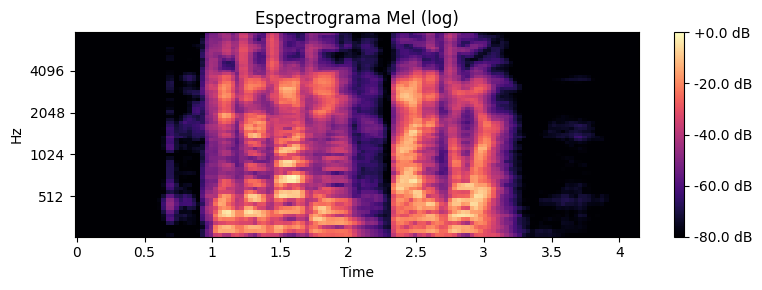

In [ ]:
import librosa, librosa.display, numpy as np, matplotlib.pyplot as plt

audio_path = os.path.join(ravdess_path, "Actor_21/03-01-05-01-01-01-21.wav" )
y, sr = librosa.load(audio_path, sr=16000, mono=True)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmin=50, fmax=7600)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(8, 3))
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="mel", fmin=50, fmax=7600)
plt.title("Espectrograma Mel (log)")
plt.colorbar(format="%+0.1f dB")
plt.tight_layout()
plt.show()

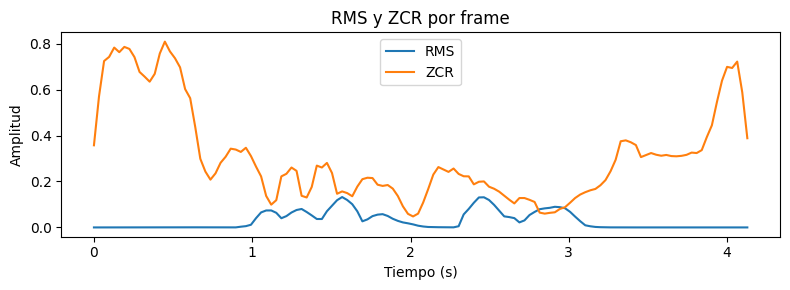

In [ ]:
import librosa, numpy as np, matplotlib.pyplot as plt

audio_path = os.path.join(ravdess_path, "Actor_21/03-01-05-01-01-01-21.wav" )
y, sr = librosa.load(audio_path, sr=16000, mono=True)

hop_length = 512
frame_times = librosa.frames_to_time(np.arange(len(y)//hop_length + 1), sr=sr, hop_length=hop_length)

rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=hop_length)[0]
zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=2048, hop_length=hop_length)[0]

plt.figure(figsize=(8, 3))
plt.plot(frame_times[:len(rms)], rms, label="RMS")
plt.plot(frame_times[:len(zcr)], zcr, label="ZCR")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("RMS y ZCR por frame")
plt.legend()
plt.tight_layout()
plt.show()

## Etiquetado y guardado del label encoder

In [ ]:
 # === ETIQUETADO RAVDESS ===
def get_emotion_label(filename):
    emotion_map = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    parts = filename.split('-')
    emotion_code = parts[2]

    return emotion_map[emotion_code]


file_emotion = []
file_chanel = []
file_path = []




for file in glob.glob(os.path.join(ravdess_path, "**", "*.wav"), recursive=True):
    name = os.path.basename(file)
    emotion= get_emotion_label(name)


    file_emotion.append(emotion)

    file_path.append(file)

emotion = pd.DataFrame(file_emotion, columns=['Emotions'])

path = pd.DataFrame(file_path, columns=['Path'])

data = pd.concat([emotion, path], axis=1)


## Extracción del caraterísticas

In [ ]:
FRAME_LENGTH = 2048
HOP_LENGTH = 512


def extract_features_emotion(data, sample_rate):
    rms = librosa.feature.rms(y=data, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)

    features = []

    # ZCR
    zcr_mean = np.mean(zcr)
    features.append(zcr_mean)

    # MFCC
    mfcc_mean = np.mean(mfcc, axis=1)
    features.extend(mfcc_mean)

    # RMS
    rms_mean = np.mean(rms)
    features.append(rms_mean)

    # Mel Spectrogram
    mel_mean = np.mean(mel, axis=1)
    features.extend(mel_mean)

    return np.array(features)

def add_silence(data, sample_rate, silence_duration=0.3):
    silence_samples = int(sample_rate * silence_duration)
    silence = np.zeros(silence_samples)
    # Insertar silencio al inicio, final o en medio (aquí al final)
    return np.concatenate([data, silence])
def noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sample_rate, steps=4):
    return librosa.effects.pitch_shift(y=data, sr=sample_rate, n_steps=steps)

def change_volume(data, gain=1.2):
    return data * gain

def augment_audio(data, sample_rate):
    augmented = []

    # Audio original
    augmented.append(data)

    # Ruido
    augmented.append(noise(data))

    # Estiramiento (velocidad)
    augmented.append(stretch(data, rate=0.9))
    augmented.append(stretch(data, rate=1.1))

    # Pitch shift
    augmented.append(pitch(data, sample_rate, steps=2))
    augmented.append(pitch(data, sample_rate, steps=-2))

    # Añadir silencio
    augmented.append(add_silence(data, sample_rate, silence_duration=0.3))

    # Cambiar volumen
    augmented.append(change_volume(data, gain=0.8))
    augmented.append(change_volume(data, gain=1.2))

    return augmented

def get_features(file):
    data, sample_rate = librosa.load(file, sr=16000, duration=2.5, offset=0.6)
    augmented_audios = augment_audio(data, sample_rate)

    features_list = []
    for audio in augmented_audios:
        features = extract_features_emotion(audio, sample_rate)
        features_list.append(features)

    return np.vstack(features_list)

In [ ]:
X, y = [], []

for file in path['Path']:
    name = os.path.basename(file)
    emotion = get_emotion_label(name)
    features = get_features(file)
    for feature in features:
        X.append(feature)
        y.append(emotion)

print(f"Total audios válidos: {len(X)}")

Total audios válidos: 12960


## Codificación de etiquetas emocionales y normalización de características

In [ ]:
# =============================
# 2. Preprocesamiento
# =============================
X = np.array(X)
le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

#Guardar scaler y encoder
joblib.dump(scaler, os.path.join(model_path, "scaler.pkl"))
joblib.dump(le, os.path.join(model_path, "label_encoder.pkl"))

# Dividir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Arquitectura del modelo
Se define una red neuronal profunda (DeepModel) implementada con PyTorch. Su entrada es un vector de 143 características acústicas, y su salida corresponde a una de las 8 emociones posibles (según el dataset RAVDESS). La arquitectura incluye:

Capas totalmente conectadas (Linear) con activación ReLU.
Regularización mediante Dropout en varias capas ocultas.
Una capa de salida con tamaño igual al número de clases emocionales.

Epoch 1/200 - Train loss: 1.7003, acc: 0.3247 - Val loss: 1.5091, acc: 0.4070
Epoch 2/200 - Train loss: 1.4398, acc: 0.4531 - Val loss: 1.3592, acc: 0.4869
Epoch 3/200 - Train loss: 1.2994, acc: 0.5143 - Val loss: 1.1769, acc: 0.5667
Epoch 4/200 - Train loss: 1.1771, acc: 0.5666 - Val loss: 1.0274, acc: 0.6219
Epoch 5/200 - Train loss: 1.0874, acc: 0.5960 - Val loss: 0.9533, acc: 0.6466
Epoch 6/200 - Train loss: 1.0095, acc: 0.6263 - Val loss: 0.8784, acc: 0.6817
Epoch 7/200 - Train loss: 0.9437, acc: 0.6540 - Val loss: 0.8229, acc: 0.6979
Epoch 8/200 - Train loss: 0.8874, acc: 0.6771 - Val loss: 0.7497, acc: 0.7296
Epoch 9/200 - Train loss: 0.8303, acc: 0.6978 - Val loss: 0.7085, acc: 0.7450
Epoch 10/200 - Train loss: 0.7801, acc: 0.7167 - Val loss: 0.6709, acc: 0.7581
Epoch 11/200 - Train loss: 0.7409, acc: 0.7274 - Val loss: 0.6238, acc: 0.7797
Epoch 12/200 - Train loss: 0.7029, acc: 0.7412 - Val loss: 0.6019, acc: 0.7897
Epoch 13/200 - Train loss: 0.6677, acc: 0.7590 - Val loss: 0.

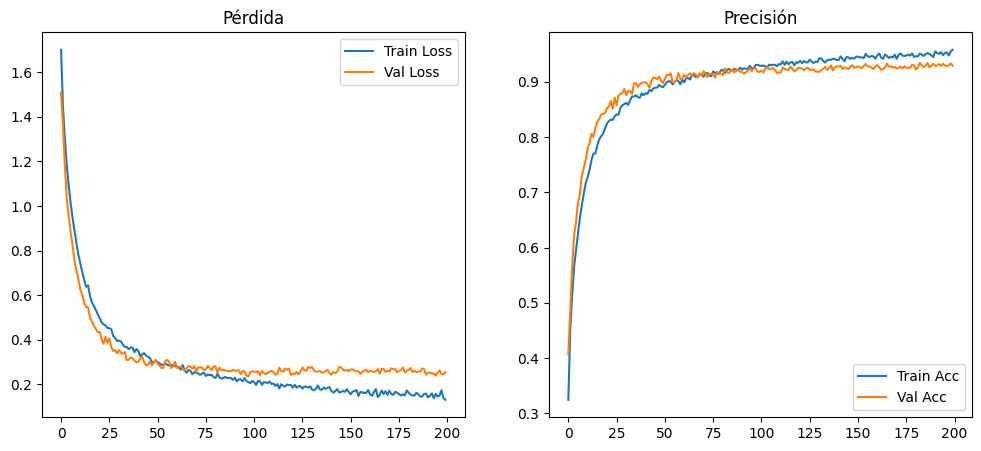

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt  # faltaba

# Definir device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir epochs (ejemplo)
epochs = 200

# Definir el modelo equivalente en PyTorch
class DeepModel(nn.Module):
    def __init__(self, input_dim=143, output_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Crear el modelo, optimizador y criterio, mover modelo a device
model = DeepModel(input_dim=143, output_dim=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # equivalente a sparse_categorical_crossentropy

# Preparar datasets y loaders (X_train, y_train, X_test, y_test deben estar definidos)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Para guardar history
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item() / len(labels)

for epoch in range(epochs):
    model.train()
    running_loss = 0
    running_acc = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_acc += (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_acc / len(train_dataset)
    history["train_loss"].append(epoch_loss)
    history["train_acc"].append(epoch_acc)

    # Validación
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(test_dataset)
    val_acc /= len(test_dataset)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} - "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

# Graficar resultados
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Pérdida")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Precisión")
plt.legend()

plt.show()




## Guardamos el modelo

In [ ]:
modelo_emociones=os.path.join(model_path, "deep_model.pth")
torch.save(model.state_dict(), modelo_emociones)

## Matriz de confusión

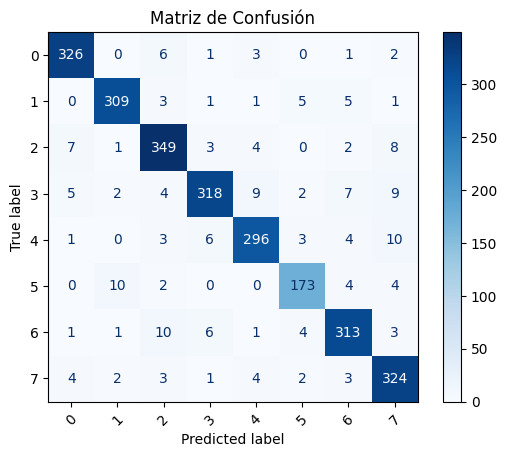

Accuracy final en test: 0.9290


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Modo evaluación
model.eval()

# Obtener todas las predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()

# Calcular y mostrar accuracy final
final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy final en test: {final_accuracy:.4f}")
